In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score 

import geopandas as gpd
import descartes

import os

# Estimate SNF locs: log regression with downsampling, var selection, regularization

In [2]:
df = pd.read_csv('/home/j/temp/beatrixh/sim_science/outputs/2020_04_23_WA_snf_dt_with_independent_vars.csv')

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (126,127,128,129,130,131,132,133,134,135,136,137) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df = df[df.total!=0]

In [4]:
df[df.elder_pct_hearing_disab=='-'].has_snf.sum()

0

In [5]:
df = df[df.elder_pct_hearing_disab!='-']

In [6]:
drop_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'GEOID',
             'state','county', 'tract', 'blkgrp', 'block', 'tract_geoid', 
             'Unnamed: 0'] #geoid
drop_cols += [col for col in df.columns if col.startswith('P0')]

df = df.drop(columns=drop_cols)

In [7]:
df.loc[df.surrounding_elder_prop.isna(),'surrounding_elder_prop'] = 0
df['prop_diff'] = df['elder_prop'] - df['surrounding_elder_prop']

## separate data into training and test sets

In [8]:
np.random.seed(1234)
train_sample = np.random.choice(df.shape[0], int(np.round(df.shape[0]*.8)), replace = False)

In [9]:
test_sample = [i for i in range(df.shape[0]) if i not in train_sample]

In [10]:
train_df = df.iloc[train_sample]
test_df = df.iloc[test_sample]

In [11]:
train_df.shape[0] + test_df.shape[0] - df.shape[0]

0

In [12]:
# this looks okay for now
print(train_df.has_snf.sum()/train_df.shape[0])
print(test_df.has_snf.sum()/test_df.shape[0])

0.0017603221284086478
0.001981700889657208


## check for collinearity

In [13]:
train_df = train_df.astype(np.float64)

In [159]:
train_df.shape

(94869, 41)

<function matplotlib.pyplot.show(*args, **kw)>

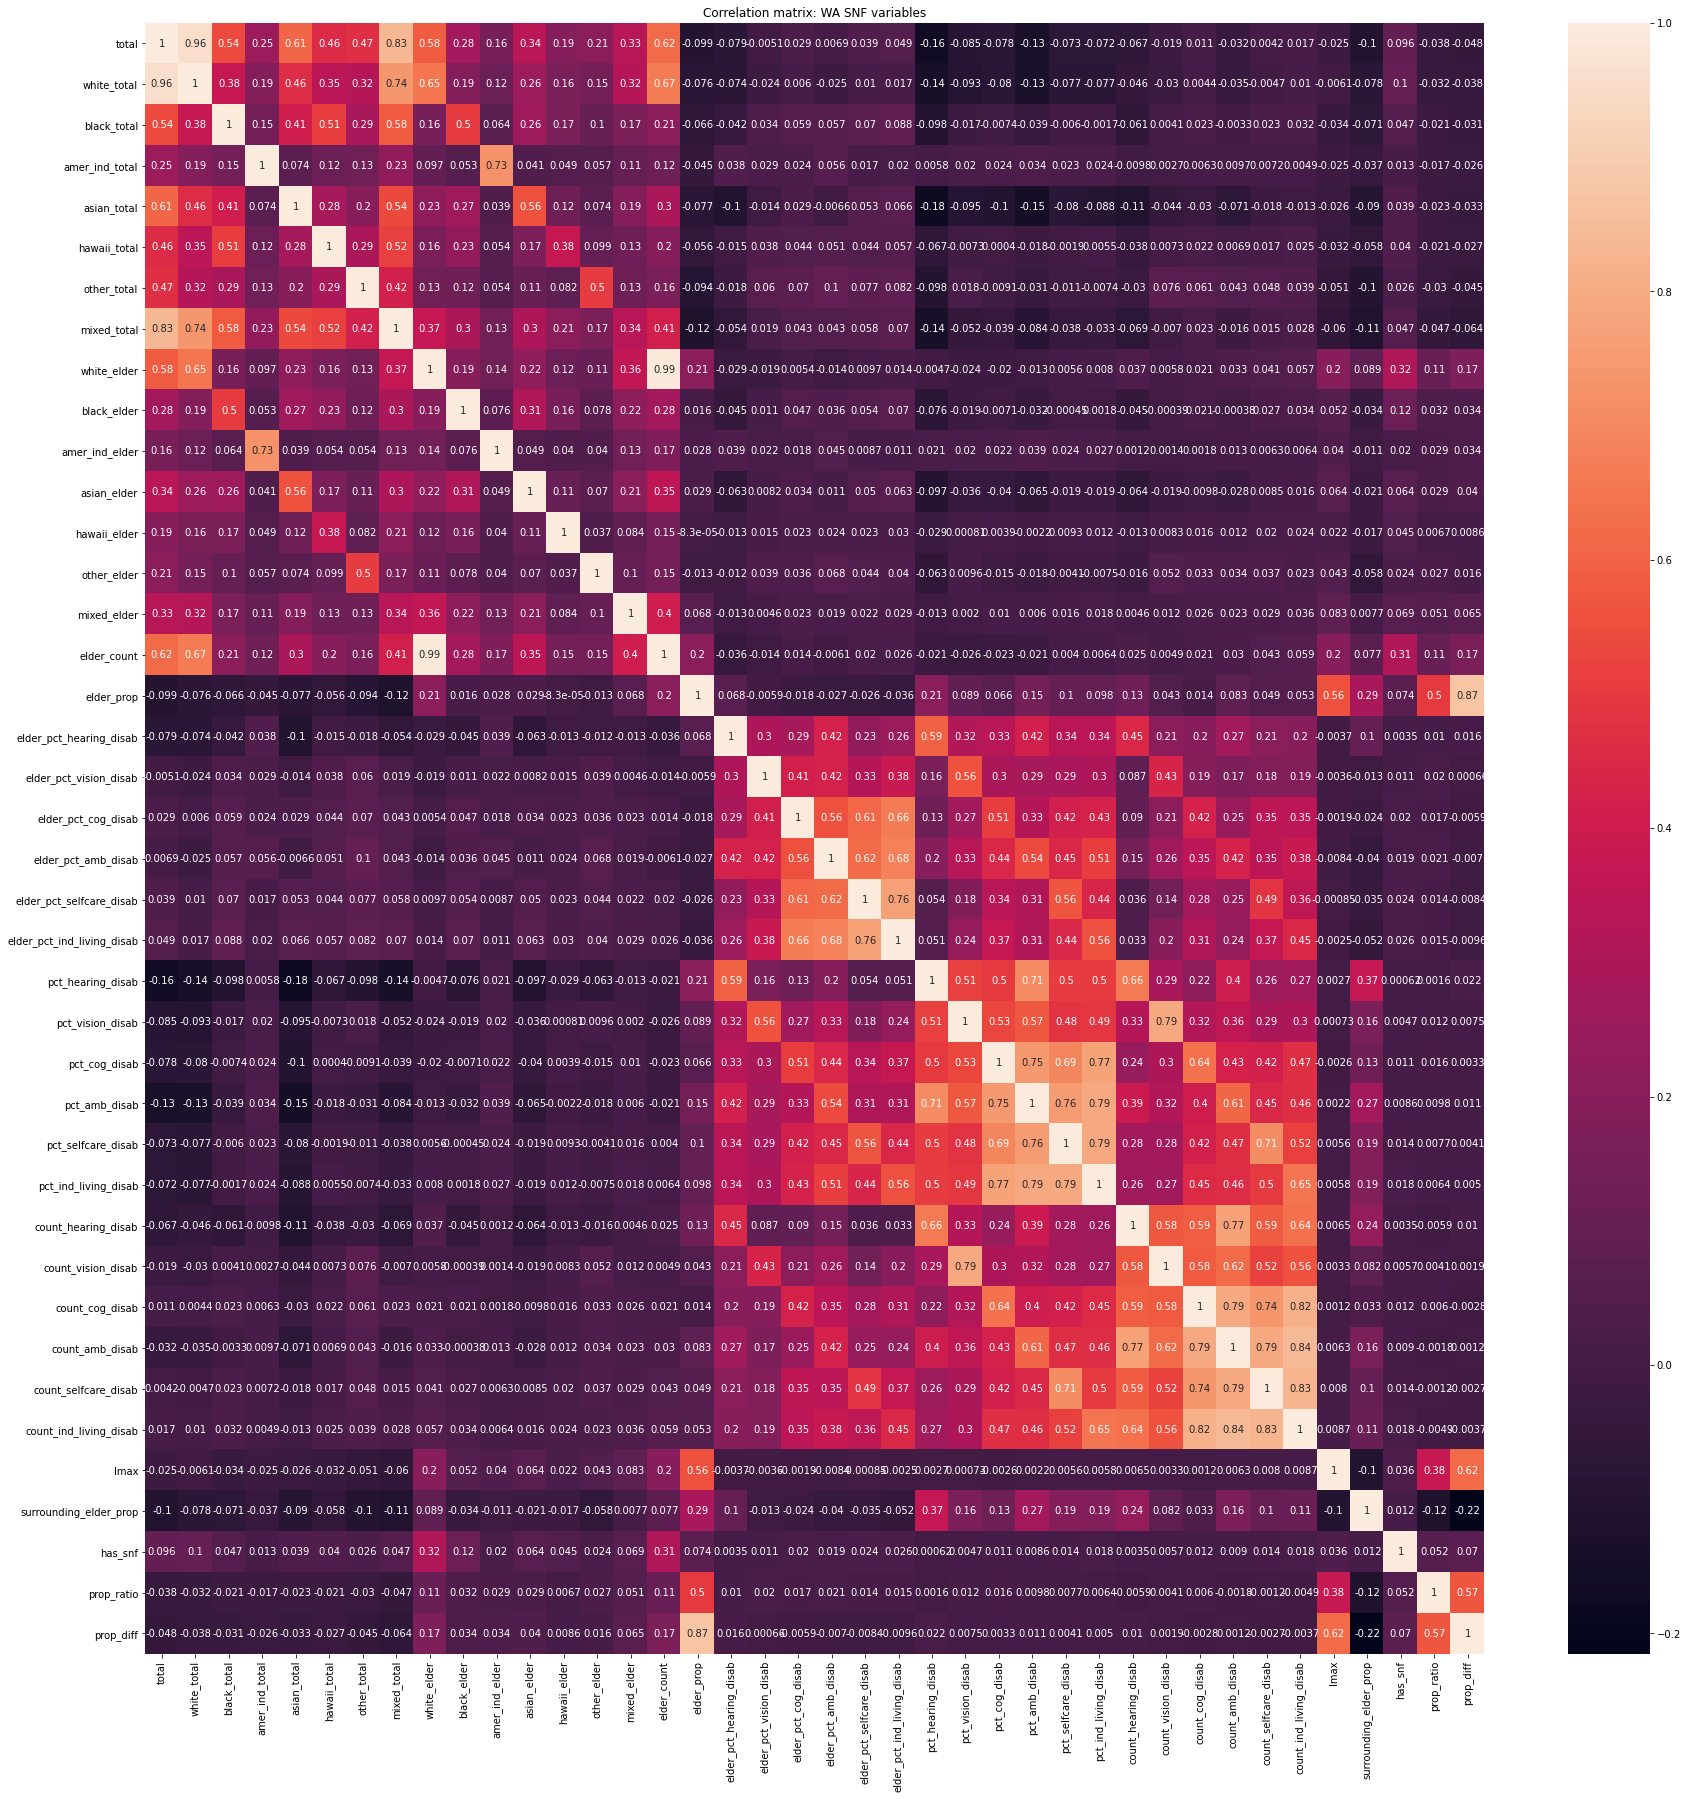

In [14]:
fig, ax = plt.subplots(figsize=(30,30))

corrMatrix = train_df.drop(columns=['geoid']).corr()
sn.heatmap(corrMatrix, annot=True)

plt.title('Correlation matrix: WA SNF variables')

plt.show
# plt.savefig('/home/j/temp/beatrixh/sim_science/outputs/corrMatrix_snfs_04_23_2020.png')

In [15]:
#Correlation with output variable
cor_target = abs(corrMatrix["has_snf"])
#Selecting correlated features
relevant_features = cor_target[cor_target>0.02].sort_values(ascending=False)
relevant_features

has_snf                       1.000000
white_elder                   0.316175
elder_count                   0.312749
black_elder                   0.119995
white_total                   0.104494
total                         0.096469
elder_prop                    0.074294
prop_diff                     0.069728
mixed_elder                   0.069341
asian_elder                   0.064409
prop_ratio                    0.052333
black_total                   0.047448
mixed_total                   0.046700
hawaii_elder                  0.045078
hawaii_total                  0.040311
asian_total                   0.039281
lmax                          0.036003
elder_pct_ind_living_disab    0.026291
other_total                   0.026025
elder_pct_selfcare_disab      0.024023
other_elder                   0.023948
amer_ind_elder                0.020002
Name: has_snf, dtype: float64

In [16]:
choose_cols = [col for col in relevant_features.index if not col.endswith('total')]

<function matplotlib.pyplot.show(*args, **kw)>

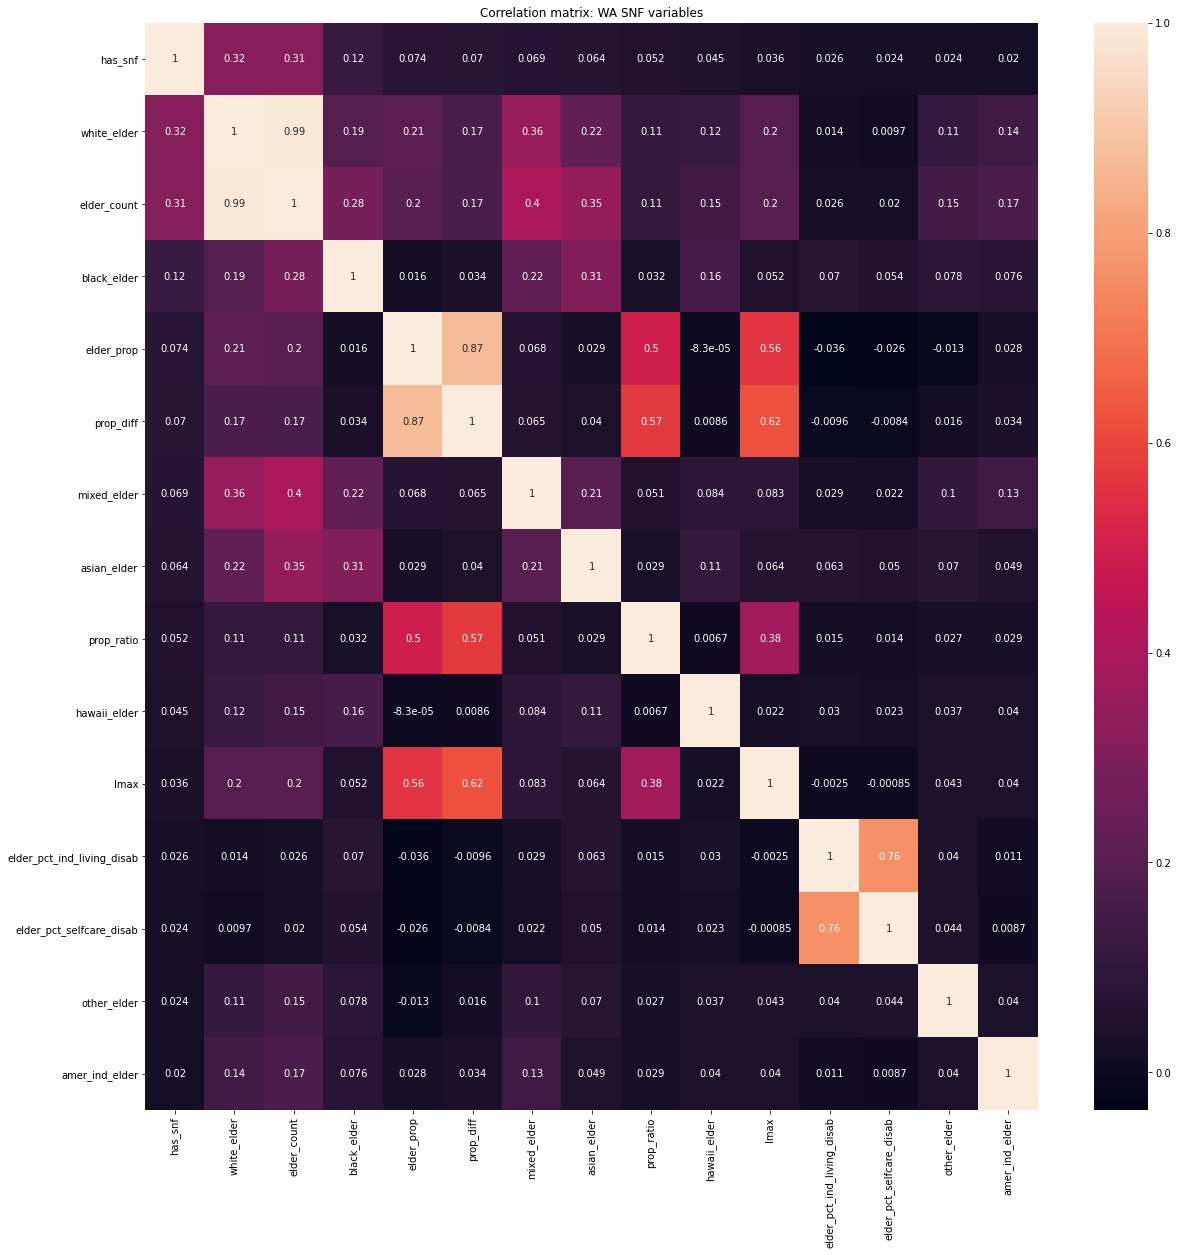

In [17]:
fig, ax = plt.subplots(figsize=(20,20))

corrMatrix = train_df[choose_cols].corr()
sn.heatmap(corrMatrix, annot=True)

plt.title('Correlation matrix: WA SNF variables')

plt.show
# plt.savefig('/home/j/temp/beatrixh/sim_science/outputs/corrMatrix_snfs_04_23_2020.png')

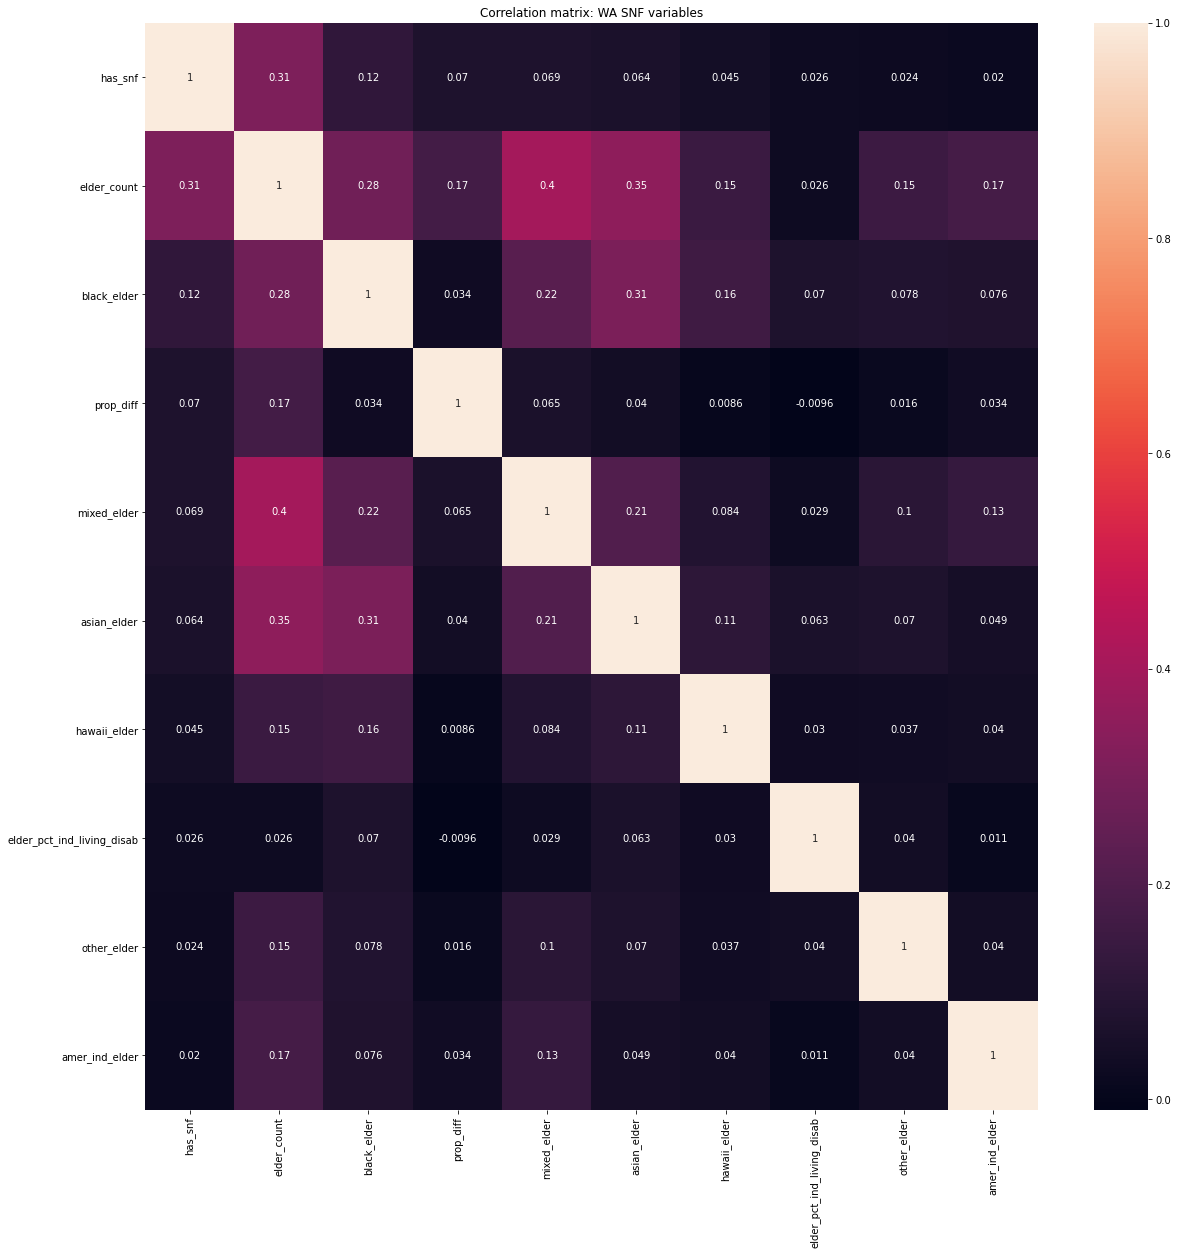

In [157]:
choose_cols2 = [col for col in choose_cols if col not in ['elder_prop','lmax','elder_pct_selfcare_disab','prop_ratio','white_elder']]

fig, ax = plt.subplots(figsize=(20,20))

corrMatrix = train_df[choose_cols2].corr()
sn.heatmap(corrMatrix, annot=True)

plt.title('Correlation matrix: WA SNF variables')

plt.show
plt.savefig('/home/j/temp/beatrixh/sim_science/outputs/corrMatrix_snfs_reduced_04_23_2020.png')

## downsample locs that have snfs

In [19]:
poss = train_df[train_df.has_snf==1]
negs = train_df[train_df.has_snf==0]

In [20]:
np.random.seed(1234)
poss_sample = np.random.randint(0,poss.shape[0],negs.shape[0]) #sample from the positives

downsampled_poss = poss.iloc[poss_sample]
weighted_dt = downsampled_poss.append(negs)

## run regression l1

In [30]:
choose_cols3 = [col for col in choose_cols2 if col!='has_snf']

# grab independent vars
X = weighted_dt[choose_cols3]
X = X.astype(np.float64)
X = np.c_[np.ones((X.shape[0], 1)), X]

# dependent var
y =weighted_dt['has_snf']

# format pred vars
X1 = test_df[choose_cols3]
X1 = X1.astype(np.float64)
X1 = np.c_[np.ones((X1.shape[0], 1)), X1]

In [40]:
model_l1 = LogisticRegression(penalty='l1', solver = 'liblinear')
model_l1.fit(X,y)
predicted_classes_l1 = model_l1.predict(X1)

In [161]:
results_l1 = pd.DataFrame(data = predicted_classes_reg, columns = ['preds'])
results_l1['actual'] = test_df.has_snf.tolist()

print(f'sensitivity (% snfs identified): {results_l1[(results_l1.actual==1)].preds.sum()/results_l1.actual.sum()}')
print(f'specificity (% non-snfs identified): {results_l1[(results_l1.actual==0) & (results_l1.preds==0)].shape[0]/results_l1[(results_l1.actual==0)].shape[0]}')
print(f'precision (true pos/all pos): {results_l1[results_l1.actual==1].preds.sum()/results_l1.preds.sum()}')
print(f'negative predictive val (true neg/all neg): {results_l1[results_l1.actual+results_l1.preds==0].shape[0]/results_l1[results_l1.preds==0].shape[0]}')

sensitivity (% snfs identified): 0.7872340425531915
specificity (% non-snfs identified): 0.9670468948035488
precision (true pos/all pos): 0.04528763769889841
negative predictive val (true neg/all neg): 0.9995633187772925


In [45]:
coefs = pd.DataFrame(data = (['intercept'] +  choose_cols3),
                     columns = ['var'])
coefs['val'] = model_l1.coef_.tolist()[0]
coefs['magnitude'] = np.abs(coefs.val)
coefs_l1 = coefs.sort_values(by=['magnitude'], ascending=False).drop(columns='magnitude')
coefs_l1

var       val
0                   intercept -1.246841
9              amer_ind_elder -1.011644
3                   prop_diff  0.789757
8                 other_elder  0.405694
2                 black_elder  0.124638
4                 mixed_elder -0.119023
1                 elder_count  0.085237
5                 asian_elder -0.041483
7  elder_pct_ind_living_disab  0.035692
6                hawaii_elder  0.023026

## run regression elastic net, ratio = 0.8

In [63]:
model_elasticnet = LogisticRegression(penalty='elasticnet', solver = 'saga', l1_ratio = 0.8)
model_elasticnet.fit(X,y)
predicted_classes_enet = model_elasticnet.predict(X1)

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [162]:
results_enet = pd.DataFrame(data = predicted_classes_enet, columns = ['preds'])
results_enet['actual'] = test_df.has_snf.tolist()

print(f'sensitivity (% snfs identified): {results_enet[(results_enet.actual==1)].preds.sum()/results_enet.actual.sum()}')
print(f'specificity (% non-snfs identified): {results_enet[(results_enet.actual==0) & (results_enet.preds==0)].shape[0]/results_enet[(results_enet.actual==0)].shape[0]}')
print(f'precision (true pos/all pos): {results_enet[results_enet.actual==1].preds.sum()/results_enet.preds.sum()}')
print(f'negative predictive val (true neg/all neg): {results_enet[results_enet.actual+results_enet.preds==0].shape[0]/results_enet[results_enet.preds==0].shape[0]}')

sensitivity (% snfs identified): 0.8085106382978723
specificity (% non-snfs identified): 0.9665821715251373
precision (true pos/all pos): 0.045838359469240045
negative predictive val (true neg/all neg): 0.9996067808458581


In [158]:
coefs = pd.DataFrame(data = (['intercept'] +  choose_cols3),
                     columns = ['var'])
coefs['beta'] = model_elasticnet.coef_.tolist()[0]
coefs['magnitude'] = np.abs(coefs.beta)
coefs_l1 = coefs.sort_values(by=['magnitude'], ascending=False).drop(columns='magnitude')
coefs_l1

var      beta
0                   intercept -1.538339
9              amer_ind_elder -0.551664
8                 other_elder  0.337042
3                   prop_diff  0.237402
4                 mixed_elder -0.149761
2                 black_elder  0.126316
1                 elder_count  0.085413
5                 asian_elder -0.041020
7  elder_pct_ind_living_disab  0.031581
6                hawaii_elder  0.021205

## run regression elastic net, ratio = 0.5

In [66]:
model_elasticnet = LogisticRegression(penalty='elasticnet', solver = 'saga', l1_ratio = 0.5)
model_elasticnet.fit(X,y)
predicted_classes_enet = model_elasticnet.predict(X1)

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [163]:
results_enet = pd.DataFrame(data = predicted_classes_enet, columns = ['preds'])
results_enet['actual'] = test_df.has_snf.tolist()

print(f'sensitivity (% snfs identified): {results_enet[(results_enet.actual==1)].preds.sum()/results_enet.actual.sum()}')
print(f'specificity (% non-snfs identified): {results_enet[(results_enet.actual==0) & (results_enet.preds==0)].shape[0]/results_enet[(results_enet.actual==0)].shape[0]}')
print(f'precision (true pos/all pos): {results_enet[results_enet.actual==1].preds.sum()/results_enet.preds.sum()}')
print(f'negative predictive val (true neg/all neg): {results_enet[results_enet.actual+results_enet.preds==0].shape[0]/results_enet[results_enet.preds==0].shape[0]}')

sensitivity (% snfs identified): 0.8085106382978723
specificity (% non-snfs identified): 0.9665821715251373
precision (true pos/all pos): 0.045838359469240045
negative predictive val (true neg/all neg): 0.9996067808458581


In [68]:
coefs = pd.DataFrame(data = (['intercept'] +  choose_cols3),
                     columns = ['var'])
coefs['val'] = model_elasticnet.coef_.tolist()[0]
coefs['magnitude'] = np.abs(coefs.val)
coefs_l1 = coefs.sort_values(by=['magnitude'], ascending=False).drop(columns='magnitude')
coefs_l1

var       val
0                   intercept -1.538403
9              amer_ind_elder -0.551605
8                 other_elder  0.336939
3                   prop_diff  0.237552
4                 mixed_elder -0.149683
2                 black_elder  0.126302
1                 elder_count  0.085411
5                 asian_elder -0.041018
7  elder_pct_ind_living_disab  0.031587
6                hawaii_elder  0.021388

## run regression elastic net, ratio = 0.2

In [75]:
model_elasticnet = LogisticRegression(penalty='elasticnet', solver = 'saga', l1_ratio = 0.2)
model_elasticnet.fit(X,y)
predicted_classes_enet = model_elasticnet.predict(X1)

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [164]:
results_enet = pd.DataFrame(data = predicted_classes_enet, columns = ['preds'])
results_enet['actual'] = test_df.has_snf.tolist()

print(f'sensitivity (% snfs identified): {results_enet[(results_enet.actual==1)].preds.sum()/results_enet.actual.sum()}')
print(f'specificity (% non-snfs identified): {results_enet[(results_enet.actual==0) & (results_enet.preds==0)].shape[0]/results_enet[(results_enet.actual==0)].shape[0]}')
print(f'precision (true pos/all pos): {results_enet[results_enet.actual==1].preds.sum()/results_enet.preds.sum()}')
print(f'negative predictive val (true neg/all neg): {results_enet[results_enet.actual+results_enet.preds==0].shape[0]/results_enet[results_enet.preds==0].shape[0]}')

sensitivity (% snfs identified): 0.8085106382978723
specificity (% non-snfs identified): 0.9665821715251373
precision (true pos/all pos): 0.045838359469240045
negative predictive val (true neg/all neg): 0.9996067808458581


In [77]:
coefs = pd.DataFrame(data = (['intercept'] +  choose_cols3),
                     columns = ['var'])
coefs['val'] = model_elasticnet.coef_.tolist()[0]
coefs['magnitude'] = np.abs(coefs.val)
coefs_l1 = coefs.sort_values(by=['magnitude'], ascending=False).drop(columns='magnitude')
coefs_l1

var       val
0                   intercept -1.538339
9              amer_ind_elder -0.551664
8                 other_elder  0.337042
3                   prop_diff  0.237402
4                 mixed_elder -0.149761
2                 black_elder  0.126316
1                 elder_count  0.085413
5                 asian_elder -0.041020
7  elder_pct_ind_living_disab  0.031581
6                hawaii_elder  0.021205

## run regression, l2 penalty

In [55]:
model_l2 = LogisticRegression(penalty='l2', solver = 'newton-cg')
model_l2.fit(X,y)
predicted_classes_l2 = model_l2.predict(X1)

In [165]:
results_l2 = pd.DataFrame(data = predicted_classes_reg, columns = ['preds'])
results_l2['actual'] = test_df.has_snf.tolist()

print(f'sensitivity (% snfs identified): {results_l2[(results_l2.actual==1)].preds.sum()/results_l2.actual.sum()}')
print(f'specificity (% non-snfs identified): {results_l2[(results_l2.actual==0) & (results_l2.preds==0)].shape[0]/results_l2[(results_l2.actual==0)].shape[0]}')
print(f'precision (true pos/all pos): {results_l2[results_l2.actual==1].preds.sum()/results_l2.preds.sum()}')
print(f'negative predictive val (true neg/all neg): {results_l2[results_l2.actual+results_l2.preds==0].shape[0]/results_l2[results_l2.preds==0].shape[0]}')

sensitivity (% snfs identified): 0.7872340425531915
specificity (% non-snfs identified): 0.9670468948035488
precision (true pos/all pos): 0.04528763769889841
negative predictive val (true neg/all neg): 0.9995633187772925


In [166]:
model_l2 = LogisticRegression(penalty='l2', solver = 'liblinear')
model_l2.fit(X,y)
predicted_classes_l2 = model_l2.predict(X1)

results_l2 = pd.DataFrame(data = predicted_classes_reg, columns = ['preds'])
results_l2['actual'] = test_df.has_snf.tolist()

print(f'sensitivity (% snfs identified): {results_l2[(results_l2.actual==1)].preds.sum()/results_l2.actual.sum()}')
print(f'specificity (% non-snfs identified): {results_l2[(results_l2.actual==0) & (results_l2.preds==0)].shape[0]/results_l2[(results_l2.actual==0)].shape[0]}')
print(f'precision (true pos/all pos): {results_l2[results_l2.actual==1].preds.sum()/results_l2.preds.sum()}')
print(f'negative predictive val (true neg/all neg): {results_l2[results_l2.actual+results_l2.preds==0].shape[0]/results_l2[results_l2.preds==0].shape[0]}')

sensitivity (% snfs identified): 0.7872340425531915
specificity (% non-snfs identified): 0.9670468948035488
precision (true pos/all pos): 0.04528763769889841
negative predictive val (true neg/all neg): 0.9995633187772925


In [167]:
model_l2 = LogisticRegression(penalty='l2', solver = 'saga')
model_l2.fit(X,y)
predicted_classes_l2 = model_l2.predict(X1)

results_l2 = pd.DataFrame(data = predicted_classes_reg, columns = ['preds'])
results_l2['actual'] = test_df.has_snf.tolist()

print(f'sensitivity (% snfs identified): {results_l2[(results_l2.actual==1)].preds.sum()/results_l2.actual.sum()}')
print(f'specificity (% non-snfs identified): {results_l2[(results_l2.actual==0) & (results_l2.preds==0)].shape[0]/results_l2[(results_l2.actual==0)].shape[0]}')
print(f'precision (true pos/all pos): {results_l2[results_l2.actual==1].preds.sum()/results_l2.preds.sum()}')
print(f'negative predictive val (true neg/all neg): {results_l2[results_l2.actual+results_l2.preds==0].shape[0]/results_l2[results_l2.preds==0].shape[0]}')

sensitivity (% snfs identified): 0.7872340425531915
specificity (% non-snfs identified): 0.9670468948035488
precision (true pos/all pos): 0.04528763769889841
negative predictive val (true neg/all neg): 0.9995633187772925


/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [168]:
model_l2 = LogisticRegression(penalty='l2', solver = 'sag')
model_l2.fit(X,y)
predicted_classes_l2 = model_l2.predict(X1)

results_l2 = pd.DataFrame(data = predicted_classes_reg, columns = ['preds'])
results_l2['actual'] = test_df.has_snf.tolist()

print(f'sensitivity (% snfs identified): {results_l2[(results_l2.actual==1)].preds.sum()/results_l2.actual.sum()}')
print(f'specificity (% non-snfs identified): {results_l2[(results_l2.actual==0) & (results_l2.preds==0)].shape[0]/results_l2[(results_l2.actual==0)].shape[0]}')
print(f'precision (true pos/all pos): {results_l2[results_l2.actual==1].preds.sum()/results_l2.preds.sum()}')
print(f'negative predictive val (true neg/all neg): {results_l2[results_l2.actual+results_l2.preds==0].shape[0]/results_l2[results_l2.preds==0].shape[0]}')

sensitivity (% snfs identified): 0.7872340425531915
specificity (% non-snfs identified): 0.9670468948035488
precision (true pos/all pos): 0.04528763769889841
negative predictive val (true neg/all neg): 0.9995633187772925


/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## plot results

In [131]:
snfs_wa = pd.read_csv('/home/j/temp/beatrixh/sim_science/snfs/WA_snfs_2010.csv')

In [132]:
# turn into geodataframe for plotting
snfs_wa = gpd.GeoDataFrame(snfs_wa,
                           geometry=gpd.points_from_xy(snfs_wa.best_long,snfs_wa.best_lat))

In [117]:
wa_block_shapes = gpd.read_file('/home/j/temp/beatrixh/sim_science/census_GIS/tl_2010_53_tabblock10/tl_2010_53_tabblock10.shp')

In [78]:
X2 = df[choose_cols3]
X2 = X2.astype(np.float64)
X2 = np.c_[np.ones((X2.shape[0], 1)), X2]

probs = model_elasticnet.predict_proba(X2)

In [110]:
map_dt = df[['geoid','has_snf']].copy(deep=True)
map_dt['probs'] = probs[:,1].tolist()

In [112]:
wa_block_shapes.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYP10', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry'],
      dtype='object')

In [118]:
wa_block_shapes.GEOID10 = wa_block_shapes.GEOID10.astype(str)
map_dt.geoid = map_dt.geoid.astype(str)

wa_map_dt = wa_block_shapes.merge(map_dt, left_on = 'GEOID10', right_on = 'geoid', how = 'left')

In [127]:
wa_map_dt.loc[wa_map_dt.probs.isna(),'probs'] = 0

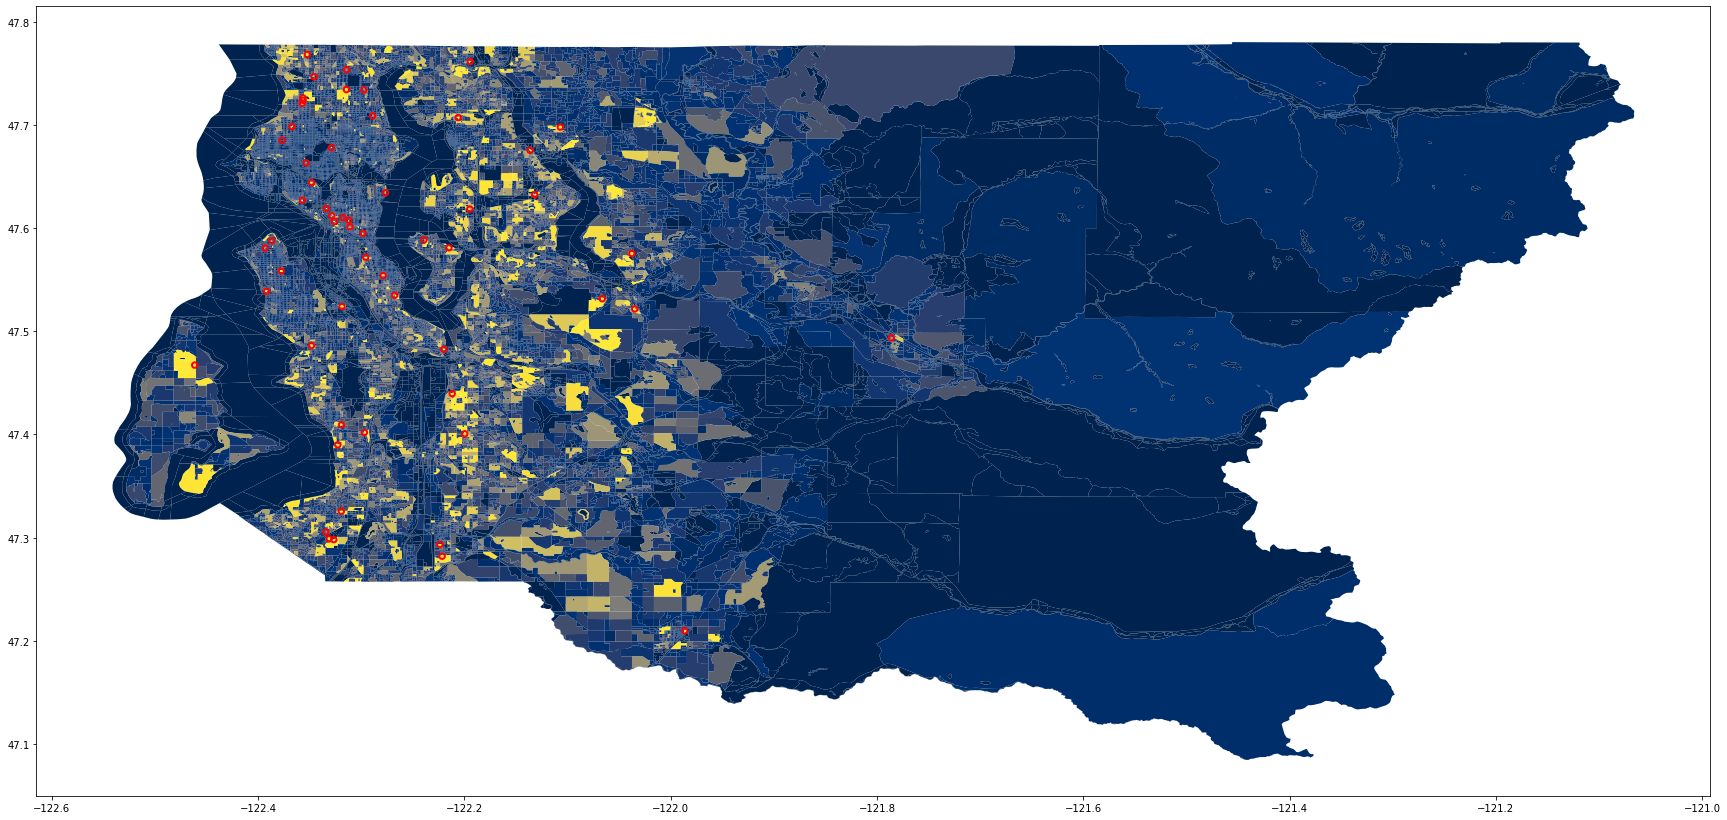

In [156]:
fig, ax = plt.subplots(figsize = (30,30))

# ax.set_xlim(-122.61, -121.8)

wa_map_dt[wa_map_dt.COUNTYFP10=='033'].plot(ax=ax, column = 'probs', cmap = 'cividis')
snfs_wa[snfs_wa.county=='KING'].plot(ax=ax, facecolors='none', edgecolors='red', linewidth=2, markersize = 30)

plt.show()

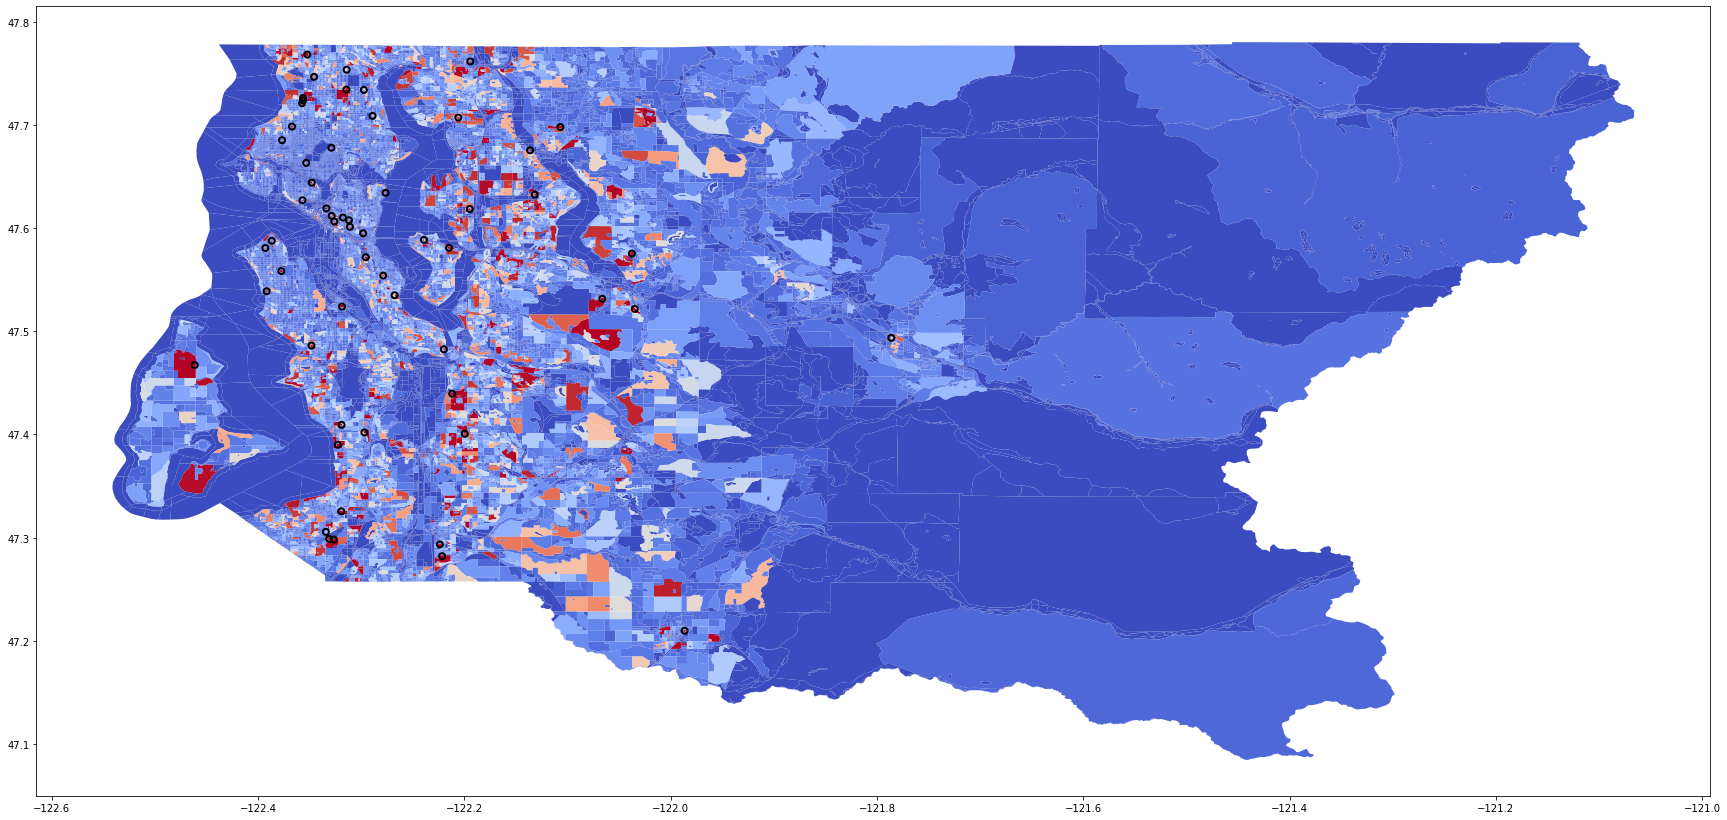

In [173]:
fig, ax = plt.subplots(figsize = (30,30))

wa_map_dt[wa_map_dt.COUNTYFP10=='033'].plot(ax=ax, column = 'probs', cmap = 'coolwarm')
snfs_wa[snfs_wa.county=='KING'].plot(ax=ax, facecolors='none', edgecolors='black', linewidth=2, legend=True,
                                    legend_kwds={'label':'SNFS'})

plt.show()

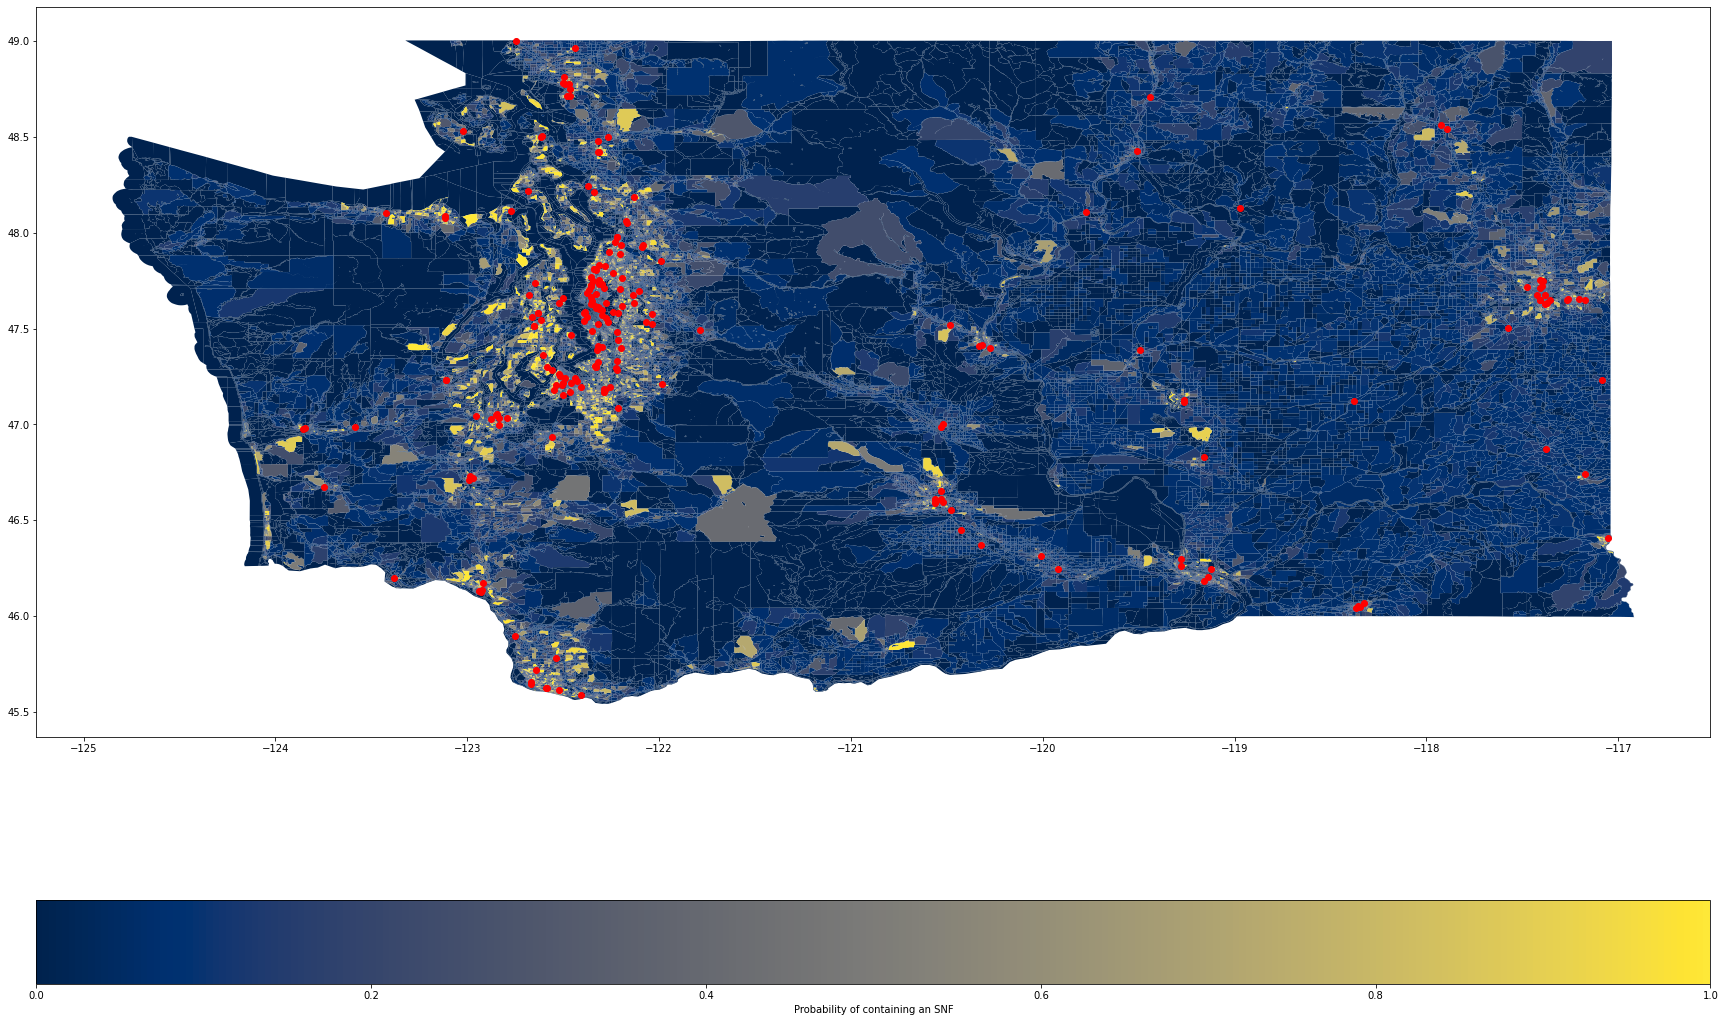

In [176]:
fig, ax = plt.subplots(figsize = (30,20))

# ax.set_xlim(-122.61, -121.8)

wa_map_dt.plot(ax=ax, column = 'probs', cmap = 'cividis',
               legend=True,
               legend_kwds={'label': "Probability of containing an SNF",
                            'orientation': "horizontal"})
snfs_wa.plot(ax=ax, color ='red')

plt.savefig('/home/j/temp/beatrixh/sim_science/outputs/WA_predicted_snfs_map_blue.png')